## Resources:

[Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)

[An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)

[Playing with time series data in python](https://towardsdatascience.com/playing-with-time-series-data-in-python-959e2485bff8)

[Time Series Analysis with Python](https://medium.com/datadriveninvestor/time-series-analysis-with-python-f5ab388b865a)


## Imports

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import pandas_profiling
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pylab as pylb
%matplotlib inline
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.dates import MonthLocator, num2date
from matplotlib.ticker import FuncFormatter
import fbprophet
import statsmodels.api as sm
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
rawData = pd.read_csv ("coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
rawData.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [3]:
rawData.describe()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,2.099760e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06,1.990691e+06
mean,1.483899e+09,3.246403e+03,3.247829e+03,3.244856e+03,3.246403e+03,7.849139e+00,3.600157e+04,3.246341e+03
std,3.638214e+07,3.799154e+03,3.801394e+03,3.796761e+03,3.799150e+03,1.873222e+01,1.401879e+05,3.799078e+03
min,1.417412e+09,6.000000e-02,6.000000e-02,6.000000e-02,6.000000e-02,1.000000e-08,2.641700e-06,6.000000e-02
25%,1.452410e+09,4.195800e+02,4.196400e+02,4.195000e+02,4.195700e+02,9.024000e-01,6.440031e+02,4.195645e+02
50%,1.483906e+09,1.014580e+03,1.014890e+03,1.014150e+03,1.014530e+03,2.692900e+00,3.695642e+03,1.014512e+03
75%,1.515402e+09,6.322630e+03,6.324010e+03,6.321090e+03,6.322670e+03,7.600965e+00,1.972392e+04,6.322550e+03
max,1.546899e+09,1.989199e+04,1.989199e+04,1.989198e+04,1.989199e+04,1.563267e+03,1.997076e+07,1.989199e+04


In [11]:
rawData.profile_report(style={'full_width':True})

## Data Cleansing and Validation

In [4]:
# Get rid of highly correlated
BTC_df = rawData.drop(['High','Low','Open','Weighted_Price'], axis=1)

In [5]:
# Delete/Replace invalid characters in column names
#https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd
BTC_df.columns = BTC_df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [6]:
#Convert date to timestamp
BTC_df ['timestamp'] =  pd.to_datetime(BTC_df ['timestamp'],unit='s')

In [7]:
#Sort by timestamp
BTC_df = BTC_df.sort_values('timestamp')

In [8]:
#Optional: Disaggregate date elements
BTC_df ['xdate'] = BTC_df ['timestamp'].dt.date
BTC_df ['xyear'] = BTC_df ['timestamp'].dt.year
BTC_df ['xmonth'] = BTC_df ['timestamp'].dt.month
BTC_df ['xday'] = BTC_df ['timestamp'].dt.day
BTC_df ['xdayofweek'] = BTC_df ['timestamp'].dt.dayofweek
BTC_df ['xhour'] = BTC_df ['timestamp'].dt.hour
BTC_df ['xminute'] = BTC_df ['timestamp'].dt.minute

In [9]:
#Set timestamp as dataframe index
BTC_df = BTC_df.set_index('timestamp')

In [10]:
BTC_df.describe()

,close,volume_btc,volume_currency,xyear,xmonth,xday,xdayofweek,xhour,xminute
count,1.990691e+06,1.990691e+06,1.990691e+06,2.099760e+06,2.099760e+06,2.099760e+06,2.099760e+06,2.099760e+06,2.099760e+06
mean,3.246403e+03,7.849139e+00,3.600157e+04,2.016520e+03,6.555234e+00,1.571748e+01,2.994419e+00,1.149942e+01,2.950030e+01
std,3.799150e+03,1.873222e+01,1.401879e+05,1.128636e+00,3.443162e+00,8.823729e+00,1.998591e+00,6.920123e+00,1.731811e+01
min,6.000000e-02,1.000000e-08,2.641700e-06,2.014000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.195700e+02,9.024000e-01,6.440031e+02,2.016000e+03,4.000000e+00,8.000000e+00,1.000000e+00,6.000000e+00,1.500000e+01
50%,1.014530e+03,2.692900e+00,3.695642e+03,2.017000e+03,7.000000e+00,1.600000e+01,3.000000e+00,1.100000e+01,3.000000e+01
75%,6.322670e+03,7.600965e+00,1.972392e+04,2.018000e+03,1.000000e+01,2.300000e+01,5.000000e+00,1.700000e+01,4.500000e+01
max,1.989199e+04,1.563267e+03,1.997076e+07,2.019000e+03,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,5.900000e+01


In [11]:
#Replace missing values with interpolation
#https://stackoverflow.com/questions/49308530/missing-values-in-time-series-in-python
BTC_df['close'].interpolate(method='time', inplace=True)
BTC_df['volume_btc'].interpolate(method='time', inplace=True)
BTC_df['volume_currency'].interpolate(method='time', inplace=True)

In [12]:
#Is there missing values?
print(BTC_df.isnull().sum())

close              0
volume_btc         0
volume_currency    0
xdate              0
xyear              0
xmonth             0
xday               0
xdayofweek         0
xhour              0
xminute            0
dtype: int64


In [13]:
#Let's work with 2017 and 2018 values only
BTC_df = BTC_df[(BTC_df['xyear'] > 2016) & (BTC_df['xyear'] < 2019)]

In [14]:
#Show dataframe range
BTC_df['xdate'].min(), BTC_df['xdate'].max()

(datetime.date(2017, 1, 1), datetime.date(2018, 12, 31))

In [15]:
BTC_df.head()

,close,volume_btc,volume_currency,xdate,xyear,xmonth,xday,xdayofweek,xhour,xminute
timestamp,,,,,,,,,,
2017-01-01 00:00:00,973.350000,2.122048,2065.524303,2017-01-01,2017,1,1,6,0,0
2017-01-01 00:01:00,973.353333,1.428032,1389.994335,2017-01-01,2017,1,1,6,0,1
2017-01-01 00:02:00,973.356667,0.734016,714.464368,2017-01-01,2017,1,1,6,0,2
2017-01-01 00:03:00,973.360000,0.040000,38.934400,2017-01-01,2017,1,1,6,0,3
2017-01-01 00:04:00,973.390000,5.458800,5313.529708,2017-01-01,2017,1,1,6,0,4


In [16]:
BTC_df.tail()

,close,volume_btc,volume_currency,xdate,xyear,xmonth,xday,xdayofweek,xhour,xminute
timestamp,,,,,,,,,,
2018-12-31 23:55:00,3685.00,10.246505,37757.750556,2018-12-31,2018,12,31,0,23,55
2018-12-31 23:56:00,3685.01,1.780986,6562.948712,2018-12-31,2018,12,31,0,23,56
2018-12-31 23:57:00,3685.01,12.726180,46896.024991,2018-12-31,2018,12,31,0,23,57
2018-12-31 23:58:00,3685.01,3.324478,12250.730602,2018-12-31,2018,12,31,0,23,58
2018-12-31 23:59:00,3691.86,25.899933,95475.036021,2018-12-31,2018,12,31,0,23,59


In [17]:
BTC_df.describe()

,close,volume_btc,volume_currency,xyear,xmonth,xday,xdayofweek,xhour,xminute
count,1.051200e+06,1.051200e+06,1.051200e+06,1051200.0,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06,1.051200e+06
mean,5.751305e+03,9.937182e+00,6.654077e+04,2017.5,6.526027e+00,1.572055e+01,3.000000e+00,1.150000e+01,2.950000e+01
std,3.747669e+03,2.099186e+01,1.913235e+05,0.5,3.447853e+00,8.796251e+00,2.003423e+00,6.922190e+00,1.731811e+01
min,6.000000e-02,8.000000e-08,6.595840e-05,2017.0,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.570575e+03,1.439184e+00,5.494333e+03,2017.0,4.000000e+00,8.000000e+00,1.000000e+00,5.750000e+00,1.475000e+01
50%,6.212660e+03,3.878059e+00,1.678112e+04,2017.5,7.000000e+00,1.600000e+01,3.000000e+00,1.150000e+01,2.950000e+01
75%,7.659045e+03,1.014517e+01,5.255633e+04,2018.0,1.000000e+01,2.300000e+01,5.000000e+00,1.725000e+01,4.425000e+01
max,1.989199e+04,1.156319e+03,1.997076e+07,2018.0,1.200000e+01,3.100000e+01,6.000000e+00,2.300000e+01,5.900000e+01


### Volume of transacted bitcoins

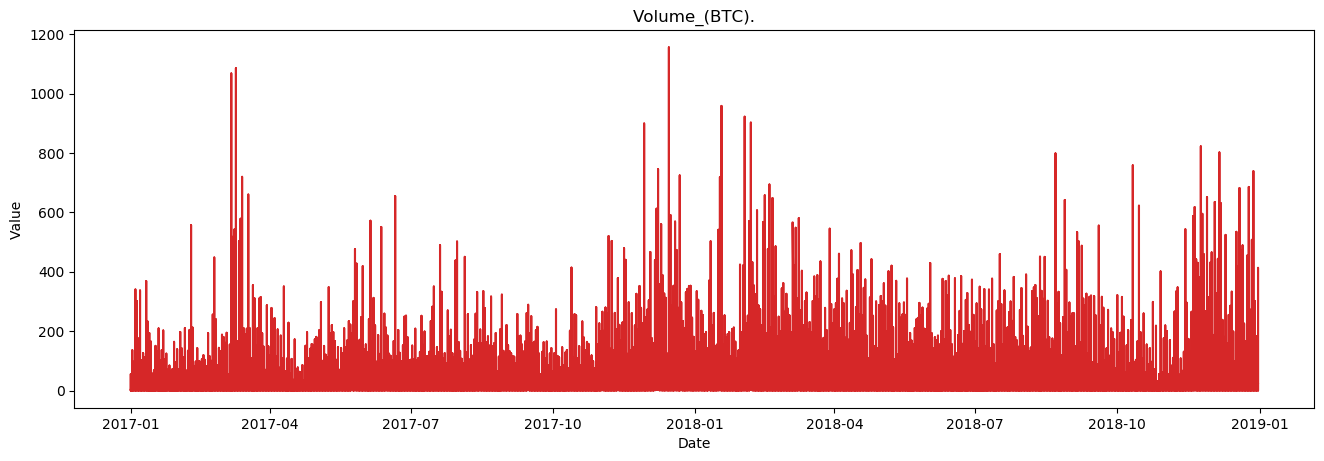

In [18]:
#Plot volume of transacted bitcoins
#https://www.machinelearningplus.com/time-series/time-series-analysis-python/
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(BTC_df, x=BTC_df.xdate, y=BTC_df.volume_btc, title='Volume_(BTC).')

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


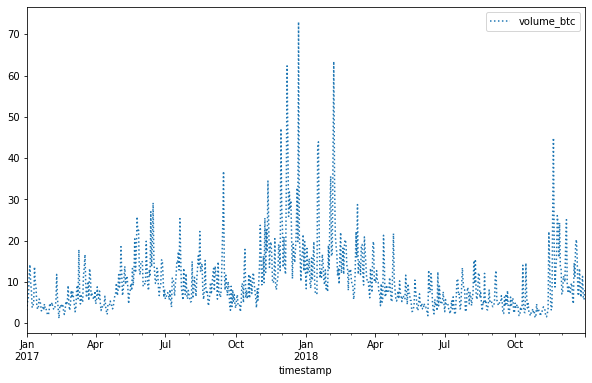

In [20]:
BTC_df_volume = BTC_df[['volume_btc']]
BTC_df_daily_vol = BTC_df_volume.resample('D').mean()
#https://stackoverflow.com/questions/43206554/typeerror-float-argument-must-be-a-string-or-a-number-not-period
pd.plotting.register_matplotlib_converters()
BTC_df_daily_vol.plot(style=[':', '--', '-'])

### Currency volume of transacted bitcoins

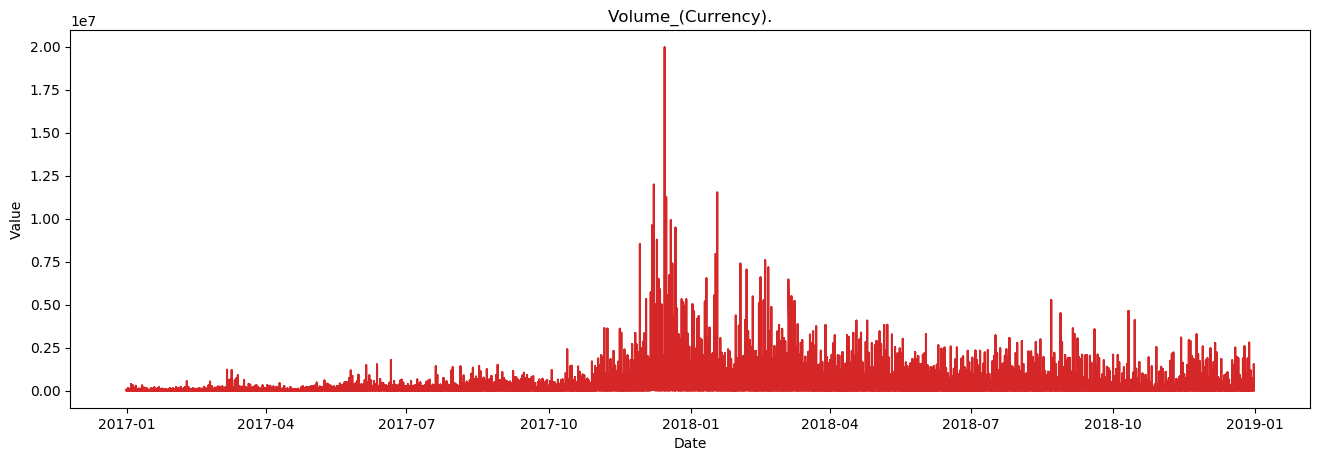

In [21]:
#Plot currency volume of transacted bitcoins
plot_df(BTC_df, x=BTC_df.xdate, y=BTC_df.volume_currency, title='Volume_(Currency).')

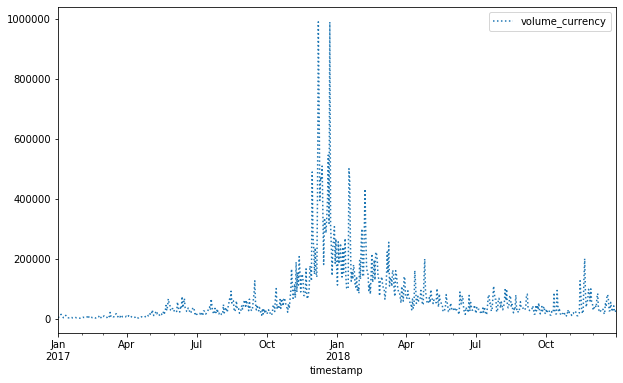

In [22]:
BTC_df_currency = BTC_df[['volume_currency']]
BTC_df_daily_curr = BTC_df_currency.resample('D').mean()
BTC_df_daily_curr.plot(style=[':', '--', '-'])

## Time series analysis

### Volume of transacted bitcoins

#### Seasonal decompose (daily)

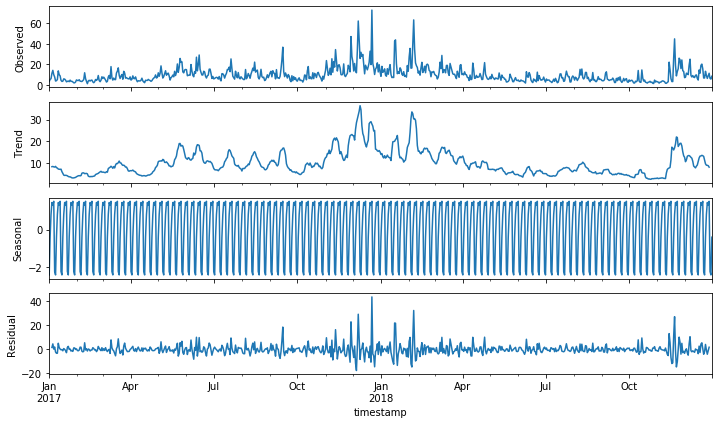

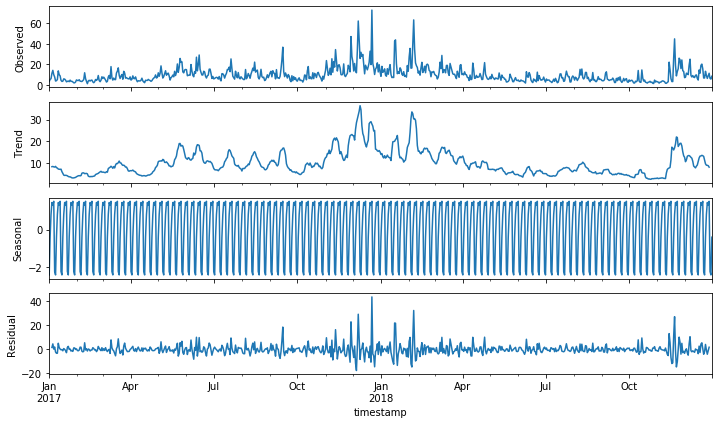

In [23]:
result = seasonal_decompose(BTC_df_daily_vol, model='additive')
result.plot()

#### Facebook prophet analysis

In [24]:
BTC_df_volume.reset_index(inplace=True)
BTC_df_volume = BTC_df_volume.rename (columns={'timestamp':'ds','volume_btc':'y'})
BTC_df_volume.head()

,ds,y
0,2017-01-01 00:00:00,2.122048
1,2017-01-01 00:01:00,1.428032
2,2017-01-01 00:02:00,0.734016
3,2017-01-01 00:03:00,0.040000
4,2017-01-01 00:04:00,5.458800


In [25]:
BTC_df_volume_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10
                                         ,yearly_seasonality=True
                                         )
BTC_df_volume_prophet.fit(BTC_df_volume)

In [26]:
BTC_df_volume_forecast = BTC_df_volume_prophet.make_future_dataframe(periods=30*2, freq='D')
BTC_df_volume_forecast = BTC_df_volume_prophet.predict (BTC_df_volume_forecast)

Text(0.5, 1, 'Two months prediction')

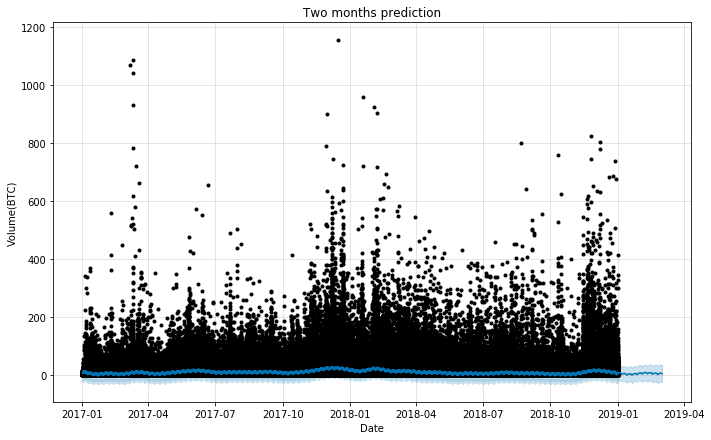

In [27]:
BTC_df_volume_prophet.plot(BTC_df_volume_forecast, xlabel='Date', ylabel='Volume(BTC)')
pylb.title('Two months prediction')

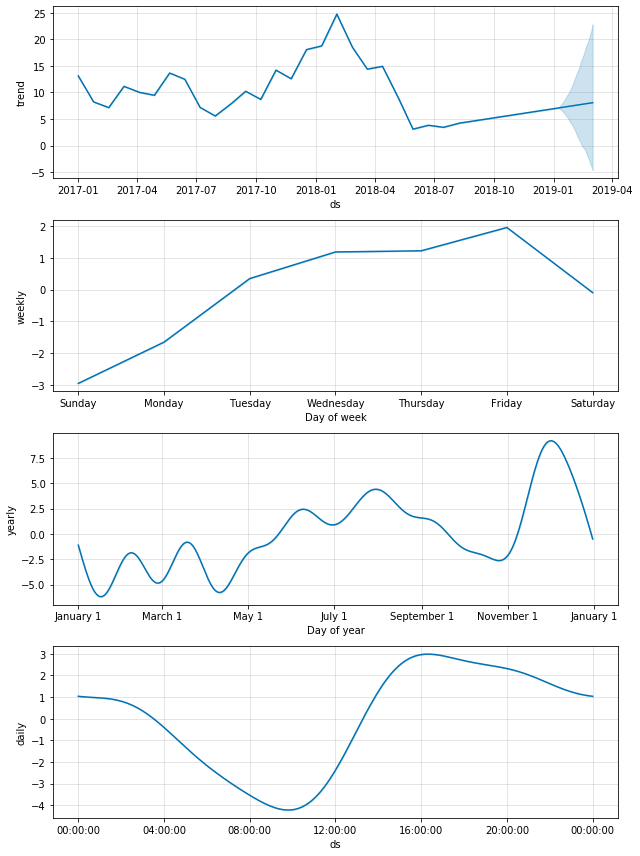

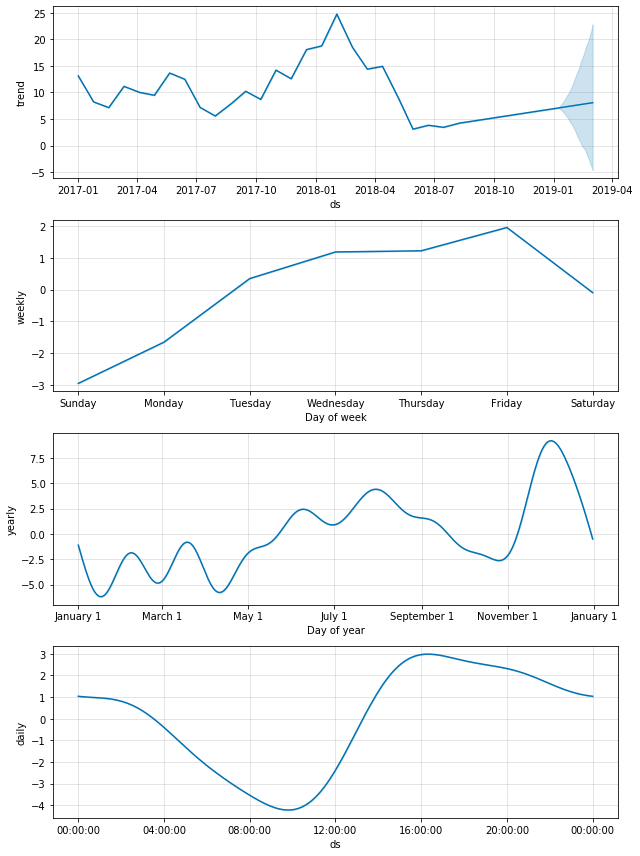

In [28]:
BTC_df_volume_prophet.plot_components(BTC_df_volume_forecast)

### Currency volume of transacted bitcoins

#### Seasonal decompose (daily)

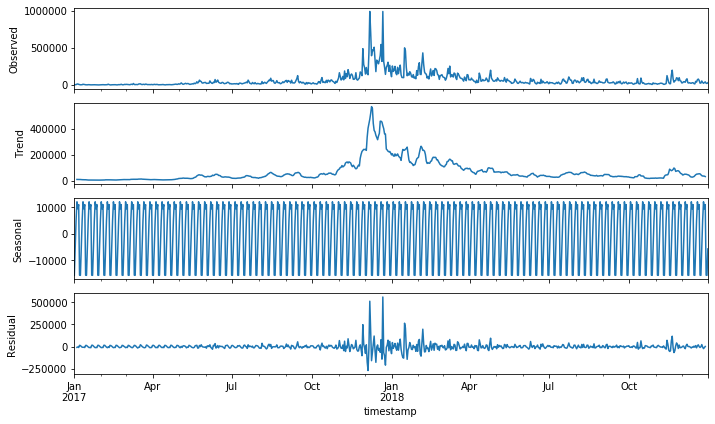

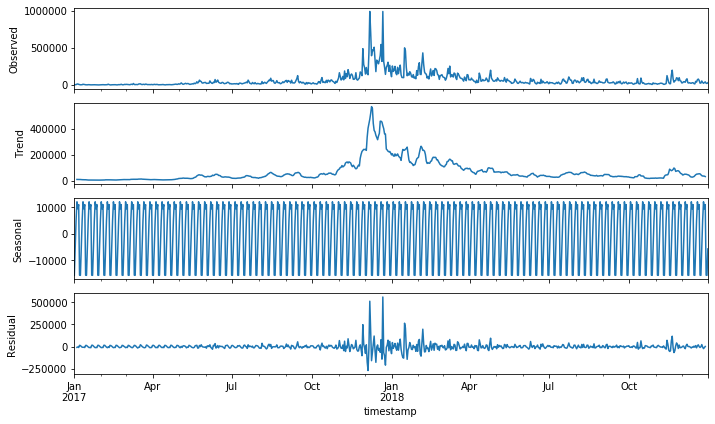

In [29]:
result = seasonal_decompose(BTC_df_daily_curr, model='additive')
result.plot()

#### Facebook prophet analysis

In [30]:
BTC_df_currency.reset_index(inplace=True)
BTC_df_currency = BTC_df_currency.rename (columns={'timestamp':'ds','volume_currency':'y'})
BTC_df_currency.head()

,ds,y
0,2017-01-01 00:00:00,2065.524303
1,2017-01-01 00:01:00,1389.994335
2,2017-01-01 00:02:00,714.464368
3,2017-01-01 00:03:00,38.934400
4,2017-01-01 00:04:00,5313.529708


In [31]:
BTC_df_currency_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10
                                            ,yearly_seasonality=True
                                            )
BTC_df_currency_prophet.fit(BTC_df_currency)

In [32]:
BTC_df_currency_forecast = BTC_df_currency_prophet.make_future_dataframe(periods=30*2, freq='D')
BTC_df_currency_forecast = BTC_df_currency_prophet.predict (BTC_df_currency_forecast)

Text(0.5, 1, 'Two months prediction')

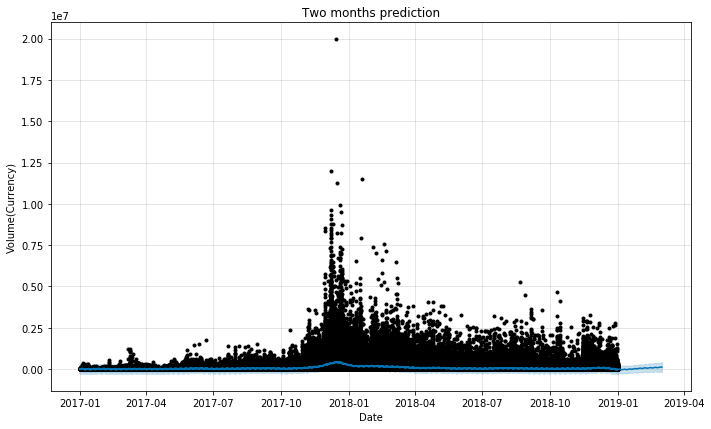

In [33]:
BTC_df_currency_prophet.plot(BTC_df_currency_forecast, xlabel='Date', ylabel='Volume(Currency)')
pylb.title('Two months prediction')

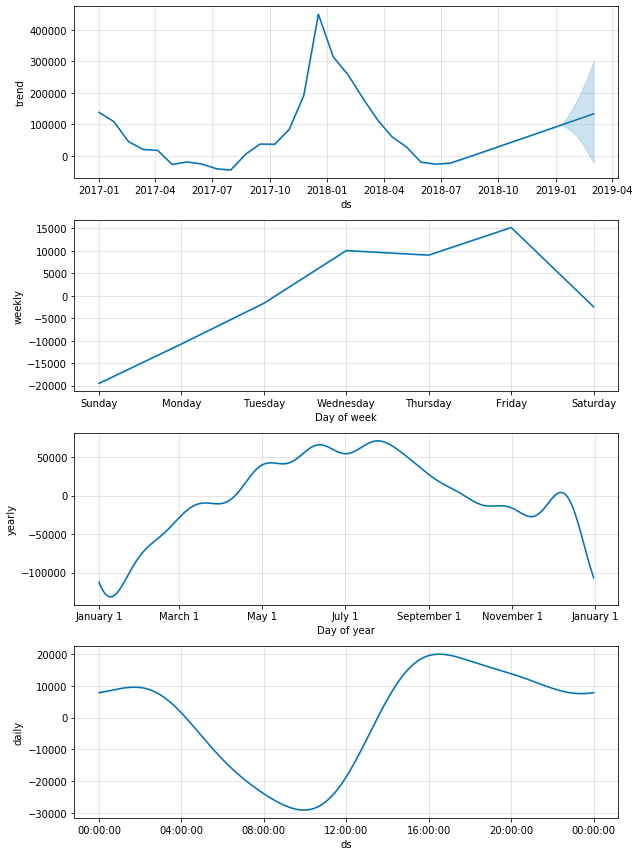

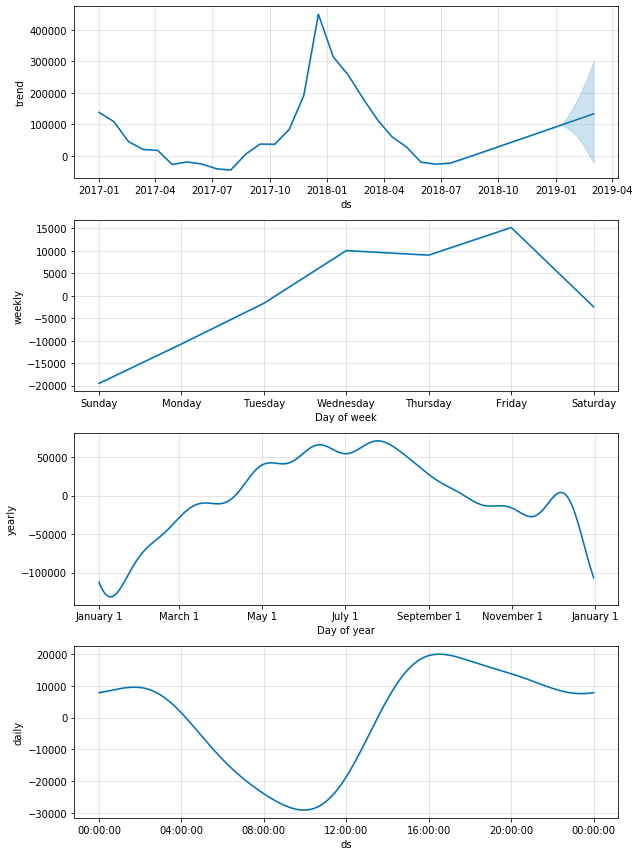

In [34]:
BTC_df_currency_prophet.plot_components(BTC_df_currency_forecast)